# Week 06 - Introduction to PyTorch

## Approximating a function (Regression using NN)

In this class, we will learn how to use a ML package like PyTorch to create a neural network (NN). NN will be used to predict an unknown function. For example, we have some dataset from experiments and we want to predict the function, similar to what we did in Linear Regression problem. But now we do that using NN. 

#### Steps in Regression

1. Prediction based on initial weights
2. Compute Loss function
3. Optimize the weights and biases
4. Update parameters

In [1]:
# Import all needed libraries
import os

import torch   # this import the PyTorch library (official website: pytorch.org)

import numpy as np
import matplotlib.pyplot as plt
import functionapproximator as fa      # this imports the functionapproximator.py module. We define all the functionalities there

# functionapproximator includes generating a NN model, training, ploting methods.

# tells matplotlib to embed plots within the notebook
%matplotlib inline

### Generating dataset

Here, we are trying to approxiamte a function $y = \sin(2 \pi x)$. We need to generate training dataset and validation dataset.
Those are generated using some random function. Here, training and validation dataset is $y = \sin(2 \pi x) +\epsilon$, and $\epsilon = 0.1*\textit{U}[-1,1]$.



40


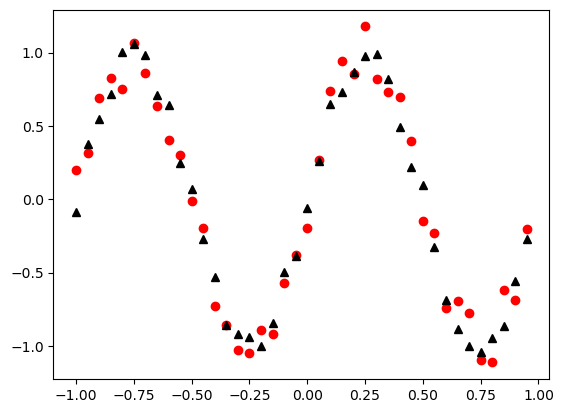

In [2]:
# just to visualize the function 
x = np.arange(-1, 1, 0.01, dtype=float)
f = np.sin(2*np.pi*x)

#plt.plot(x,f,'b--')
#plt.xlabel('x values')
#plt.ylabel('y = $\sin(2\pi x)$')

# generating training dataset (40 Samples)
x1 = np.arange(-1, 1, 0.05, dtype=float)
print(len(x1))
rnd1 = 0.2*np.random.uniform(-1, 1, 40)
f_train = np.sin(2*np.pi*(x1))+rnd1
plt.plot(x1,f_train,'ro')
np.savetxt('torch_traindata.txt',(x1,f_train),delimiter=',')

# generating validation dataset (40 Samples)
x11 = np.arange(-1, 1, 0.05, dtype=float)
rnd11 = 0.1*np.random.uniform(-1, 1, 40)
f_validate = np.sin(2*np.pi*(x11))+rnd11
plt.plot(x11,f_validate,'k^')
np.savetxt('torch_valdata.txt',(x11,f_validate),delimiter=',')

#plt.legend(['True function','Training samples','Validaton samples'], loc='upper right')

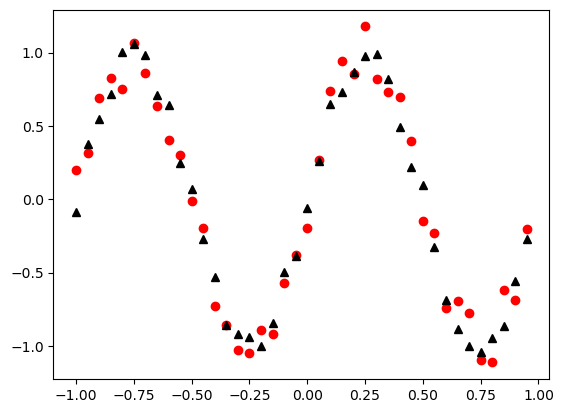

In [3]:
data = np.loadtxt('torch_traindata.txt', delimiter=',')
data1 = np.loadtxt('torch_valdata.txt', delimiter=',')
x1 = data[0,:]
f_train = data[1,:]
plt.plot(x1,f_train,'ro')

x11 = data1[0,:]
f_validate = data1[1,:]
plt.plot(x11,f_validate,'k^')

### Objective of the lab
Develop a fully connected Neural Network (NN) model to solve the regression problem using PyTorch package.

### Creating a main function

In this part, we call the methods in a `functionapproximator` module to create a NN, train it, and plot various results.
#### Code flow
1. Build the network with known dimension.
2. Initialize the weights and biases. 
3. Train the network. This contains optimizing the weights using backpropagation and updating those weights using step() method.
4. Plot the cost function history wrt epochs.

#### Explanation of the some methods

1. `torch.from_numpy()` - It creates a tensor from numpy array. 
2. `x1.astype(np.float32)` - Copy of the array x1, cast to a specified type float32. Convert x1 to float32 datatype (by default it considers float64) which the method `torch.from_numpy()` can read. Otherwise there will be an error "Expected object of scalar type Float but got scalar type Double".

3. `f_train.view(f_train.shape[0], 1)` - `.view()` returns the same data with different shape. Can also try `f_train.reshape()`
    
   For example:
   ```python
   >> x = torch.randn(2, 3) # creates a tensor of size 2x3.
   >> print(x)              
   >> x.size()
   >> x.view(x.shape[0],3)  # Will create x tensor with size(x.shape[0]=2,3=column)
   >> x.view(-1,6)          # 2nd is column size and row size will be automatically adjusted accordingly 
                           # if we use -1 instead of .shape(), or just give a row value
   #This will print x of size(1x6)
   >> x.view(-1,4) # this will give an error "shape '[-1, 4]' is invalid for input of size 6"
   >> #This means we cannot arrange a 2x3 matrix to mx4 matrix dim. 
   ```
4. `y_test.detach().numpy()` - `detach()` method detaches tensor from the computation history, and `numpy()` converts it in ndarray dtype. In case we don't need backpropagation and just use `torch.tensor` to perform math operation we can use `torch.no_grad()` method, and we don't need `detach()` method.

In [4]:
# Define the size of the neural network. Here, it is fully connected 1-2-1 with 50 neurons in each hidden layer.

input_size = 1
hidden_size = [50,50]
#hidden_size = np.array((50,2)) # Another way to define the hidden layer dimension
output_size = 1

# Generate NN 
# 1 way
# model = fa.buildModel(input_size, hidden_size, output_size)

# this is another way. import functionapproximator (all classes in filename.py) as fa (shortkey)
model_NN = fa.FunctionApproximator(input_size, hidden_size, output_size)

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


In [5]:
# Before training we need to do some datatype conversion, so that torch can understand the datatype created in numpy.
# In torch datatype is tensor, and numpy it is ndarray. 
# Use torch.utils.data.DataLoader to import data in pytorch

#x_train = torch.tensor(x1)
#print(x_train)
#x_validate = torch.tensor(x11)

x_train = torch.from_numpy(x1.astype(np.float32))
x_validate = torch.from_numpy(x11.astype(np.float32))
f_train = torch.from_numpy(f_train.astype(np.float32))
f_validate = torch.from_numpy(f_validate.astype(np.float32))

#print(x_train)
#print(x_train.shape)

# here .view() is used so that we can send 1 by 1 input data to the network.
f_train = f_train.view(f_train.shape[0], 1)
f_validate = f_validate.view(f_validate.shape[0], 1)
x_train = x_train.view(x_train.shape[0], 1)
x_validate = x_validate.view(x_validate.shape[0], 1)

#print(x_train)
#print(x_train.shape)

### Tensor.backward()

This method computes the gradient of loss function with respect to weights and biases. This uses automatic differentiation (autodiff). In autodiff, we need to
1. Calculate the loss function in forward pass.
2. Calculate the local gradients.
3. Calculate $\frac{d loss}{dw}$ using chain rule.

In this code, 1st step is calculated in cost. 2nd & 3rd step is done in backward() method.

In [6]:
# Train the model
epoch = 1000
learning_rate =0.001
weightdecay =1e-5

# Here we need both training set and validation set both as an argument.
# Training set is to train the network, Validation set is select the hyperparameters, 
# Test set is to test whether the network is predicting correct or not.
#model_NN.train(x_train, x_validate, f_train, f_validate, epoch, lr=learning_rate)
model_NN.train(x_train, x_validate, f_train, f_validate, epoch, lr=learning_rate, weight_decay = weightdecay )

Epoch: 0, Cost: 0.8322178721427917


(999, array(0.44629407, dtype=float32))

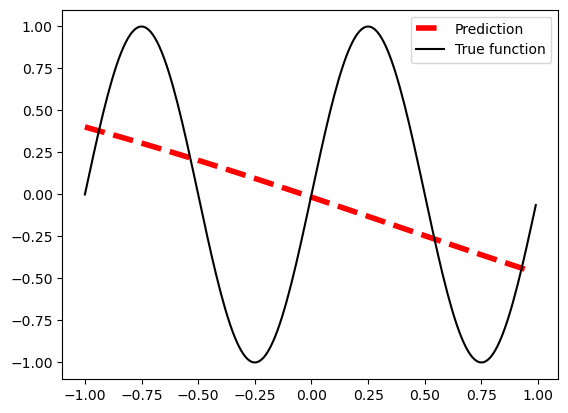

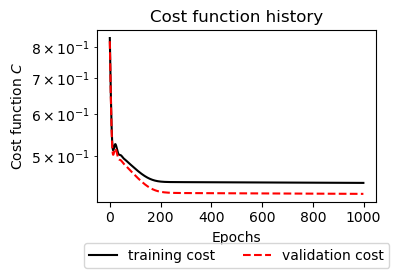

In [7]:
# just to visualize the function 
x = np.arange(-1, 1, 0.01, dtype=float)
f = np.sin(2*np.pi*x)

# Testing or prediction
x111 = np.arange(-1, 1, 0.05, dtype=float)
x_test = torch.from_numpy(x111.astype(np.float32))
x_test = x_test.view(x_test.shape[0], 1)
y_test = model_NN.predict(x_test)

plt.plot(x_test,y_test.detach().numpy(),'r--', linewidth=4)
plt.plot(x,f,'k') # analytical function

plt.legend(['Prediction', 'True function', 'Training data'],loc='upper right')

# ploting
# plot the cost function vs epochs
model_NN.plotTrainingHistory()